On this notebook I obtain a sample of 12k reviews from the original Yelp dataset. 

For analysis purposes I simplify the starts rating into two labels: 0 = negative and 1 = positive. 
The sample dataset contains the review text, the label and the reviews' business categories.

I divide this sample dataset on a train, test and validation set.

And at the end I do a quick EDA to all datasets.

This are the noteboooks I take as reference to process the Yelp dataset: [Sentiment analysis with Yelp and BERT](https://signal.onepointltd.com/post/102gc83/sentiment-analysis-with-yelp-and-bert), [Gil Mendez's repository](https://github.com/onepointconsulting/yelp_bert/blob/master/preprocess_data.ipynb), [Sentiment Analysis on Yelp reviews](https://github.com/Sonull/Sentiment-Analysis-on-Yelp-Reviews/blob/master/RF_and_SVM1.ipynb)



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from pathlib import Path
import json
import seaborn as sns
from collections import Counter
import re
from sklearn.model_selection import train_test_split

/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/Dataset_Agreement.pdf


## Obtaining a sample of the reviews

In [5]:
review_file = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'

In [10]:
sample_size = 40000 # I reduced the size of sample considerably
simplified_reviews = './yelp_reviews_simple_{sample_size}.json'

def extract_simplified(source, target, lines=1000):
    with open(target, 'w') as sr:
        cnt = 0;
        with open(source) as file:
            line = file.readline()
            while line:
                cnt += 1
                if cnt == lines:
                    break
                if cnt % 100_000 == 0:
                    print(f'Processed {cnt}')
                try:
                    line = file.readline().strip()
                    review_dict = json.loads(line)
                    simplified = {'text':  review_dict['text'], 'stars': review_dict['stars'], 'business_id': review_dict['business_id']}
                    simplified_text = json.dumps(simplified)
                    sr.write(f'{simplified_text}\n')
                except:
                    print(f'Could not parse {line}')
                    
extract_simplified(review_file, simplified_reviews, lines=sample_size)

In [14]:
simplified_reviews_pd = pd.read_json(simplified_reviews, lines=True)
simplified_reviews_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         39999 non-null  object
 1   stars        39999 non-null  int64 
 2   business_id  39999 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [13]:
simplified_reviews_pd.shape

(39999, 3)

In [15]:
simplified_reviews_pd.head()

,text,stars,business_id
0,I am actually horrified this place is still in...,1,lbrU8StCq3yDfr-QMnGrmQ
1,I love Deagan's. I do. I really do. The atmosp...,5,HQl28KMwrEKHqhFrrDqVNQ
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1,5JxlZaqCnk1MnbgRirs40Q
3,"Oh happy day, finally have a Canes near my cas...",4,IS4cv902ykd8wj1TR0N3-A
4,This is definitely my favorite fast food sub s...,5,nlxHRv1zXGT0c0K51q3jDg


### Balancing the dataset and obtaining only 2 labels

In [16]:
simplified_reviews_pd['stars'].value_counts()

5    17495
4     9218
1     5593
3     4445
2     3248
Name: stars, dtype: int64

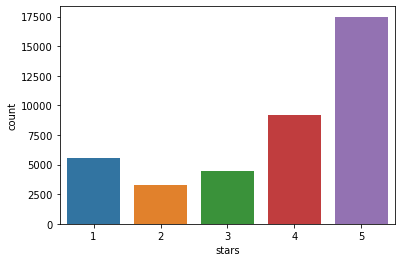

In [17]:
sns.countplot(simplified_reviews_pd['stars'])

In [18]:
# EXPLAIN
counter_star = Counter(simplified_reviews_pd['stars'])

In [19]:
# EXPLAIN
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(2, 3248)

In [20]:
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts

{1: 2345, 5: 14247, 4: 5970, 3: 1197, 2: 0}

In [21]:
remove_amounts[1] -= 1
remove_amounts

{1: 2344, 5: 14247, 4: 5970, 3: 1197, 2: 0}

In [22]:
%%time
drop_indices = []
for index, row in simplified_reviews_pd.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

CPU times: user 3.06 s, sys: 1.1 ms, total: 3.06 s
Wall time: 3.06 s


23758

In [23]:
balanced_simplified_reviews = simplified_reviews_pd.drop(drop_indices)

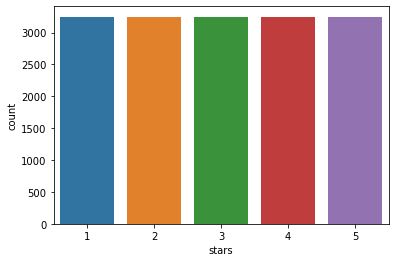

In [24]:
sns.countplot(balanced_simplified_reviews['stars'])

In [25]:
balanced_simplified_reviews['stars'].unique()

array([2, 3, 1, 4, 5])

In [26]:
# dropping reviews with 3 stars
balanced_simplified_reviews.drop(balanced_simplified_reviews.index[balanced_simplified_reviews['stars'] == 3], inplace = True)
print('yelp_reviews labels: ' + str(balanced_simplified_reviews.stars.unique()))
print('yelp_reviews shape: ' + str(balanced_simplified_reviews.shape))


yelp_reviews labels: [2 1 4 5]
yelp_reviews shape: (12993, 3)


In [27]:
# changing to only 2 labels: 0=negative, 1=positive
balanced_simplified_reviews['label'] = balanced_simplified_reviews['stars'].replace({1:0,2:0,4:1,5:1})
balanced_simplified_reviews['stars'].value_counts()

In [29]:
balanced_simplified_reviews.head(2)

,text,stars,business_id,label
31,This actually used to be one of my favorite ho...,2,LkMtMHVetws5_7QfRjPtlg,0
62,Decent food. Fishermen lobster or even congee ...,2,eNFubUPJR7yIQah-NxZN_g,0
77,"Pros: Fun atmosphere, great for people watchin...",2,l_kefVF1frmC0xRW2YkvUA,0
85,"I love bookstores, and I love to spend some ti...",2,V2TN04eMwKJmGki8ioOY9A,0
86,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",2,vQMcpsCYhkpJKvkity2VHA,0


In [30]:
balanced_simplified_reviews.drop('stars',inplace=True,axis = 1)
balanced_simplified_reviews.head(2)

In [41]:
balanced_simplified_reviews.reset_index(drop=True, inplace=True)
balanced_simplified_reviews.head(2)

,text,business_id,label
0,This actually used to be one of my favorite ho...,LkMtMHVetws5_7QfRjPtlg,0
1,Decent food. Fishermen lobster or even congee ...,eNFubUPJR7yIQah-NxZN_g,0


In [43]:
balanced_simplified_reviews.shape

(12993, 3)

## Getting the business categories for each review

In [32]:
import time
def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [33]:
%%time
print('loading business data...')
business_df = read_json('../input/yelp-dataset/yelp_academic_dataset_business.json')

loading business data...
CPU times: user 3.93 s, sys: 580 ms, total: 4.51 s
Wall time: 4.49 s


In [34]:
business_df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None


In [35]:
len(business_df.categories.unique())

102495

In [53]:
business_df.categories.unique()[:10]

array(['Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping',
       'Health & Medical, Fitness & Instruction, Yoga, Active Life, Pilates',
       'Pets, Pet Services, Pet Groomers',
       'Hardware Stores, Home Services, Building Supplies, Home & Garden, Shopping',
       'Home Services, Plumbing, Electricians, Handyman, Contractors',
       'Auto Repair, Automotive, Oil Change Stations, Transmission Repair',
       'Dry Cleaning & Laundry, Local Services, Laundry Services',
       'Auto Repair, Oil Change Stations, Automotive, Tires',
       'Ethnic Food, Food Trucks, Specialty Food, Imported Food, Argentine, Food, Restaurants, Empanadas',
       'Martial Arts, Gyms, Fitness & Instruction, Active Life'],
      dtype=object)

In [44]:
business_df.categories[business_df['business_id'].isin([balanced_simplified_reviews['business_id'][1]]) == True]

17384    Seafood, Restaurants, Food, Chinese, Seafood M...
Name: categories, dtype: object

In [49]:
# labels: 0=negative, 1=positive
categories_id = business_df[['business_id','categories']]
balanced_reviews = balanced_simplified_reviews.merge(categories_id, how='left', on='business_id')
balanced_reviews.head()

,text,business_id,label,categories
0,This actually used to be one of my favorite ho...,LkMtMHVetws5_7QfRjPtlg,0,"Casinos, Nightlife, Restaurants, Hotels & Trav..."
1,Decent food. Fishermen lobster or even congee ...,eNFubUPJR7yIQah-NxZN_g,0,"Seafood, Restaurants, Food, Chinese, Seafood M..."
2,"Pros: Fun atmosphere, great for people watchin...",l_kefVF1frmC0xRW2YkvUA,0,"Nightlife, Bars, American (Traditional), Music..."
3,"I love bookstores, and I love to spend some ti...",V2TN04eMwKJmGki8ioOY9A,0,"Shopping, Bookstores, Books, Mags, Music & Video"
4,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",vQMcpsCYhkpJKvkity2VHA,0,"Burgers, Restaurants, Salad, Sandwiches"


In [78]:
print(balanced_reviews.shape)
print(len(balanced_reviews.categories.unique()))

(12993, 4)
4000


In [54]:
balanced_reviews.categories.unique()[:10]

array(['Casinos, Nightlife, Restaurants, Hotels & Travel, Tennis, Active Life, Steakhouses, Event Planning & Services, Music Venues, Sushi Bars, Arts & Entertainment, Food, Japanese, Hotels',
       'Seafood, Restaurants, Food, Chinese, Seafood Markets, Specialty Food, Dim Sum, Japanese',
       'Nightlife, Bars, American (Traditional), Music Venues, Dance Clubs, Restaurants, Arts & Entertainment, Beer, Wine & Spirits, Cocktail Bars, Lounges, Food, Event Planning & Services, Sports Bars, Venues & Event Spaces',
       'Shopping, Bookstores, Books, Mags, Music & Video',
       'Burgers, Restaurants, Salad, Sandwiches',
       'Restaurants, Asian Fusion, Japanese, Bars, Sushi Bars, Nightlife',
       'Pet Groomers, Pet Services, Pets',
       'Japanese, Sushi Bars, Restaurants', 'Hotels & Travel, Airports',
       'Nightlife, Dance Clubs'], dtype=object)

In [79]:
balanced_reviews[balanced_reviews.categories.isna() == True]


,text,business_id,label,categories
2410,"*Okay, this is strictly based on their ""10,000...",aUluscKiuPmd8L2K7-FvyA,0,None
4744,Houses The Light Factory and McGlohn Theater. ...,1rgJ-WYCEWM-RIyQN6AteA,1,None
5985,My friend tried so hard to work with this guy....,3stT022u8m1H37mcopGuUA,0,None
8442,STAY CLEAR! Canmax sales reps promise a great...,eefO7_-EYi7f4V9RwckKgg,0,None


In [75]:
balanced_reviews.label.value_counts()

0    6497
1    6496
Name: label, dtype: int64

## Cleaning the reviews

In [80]:
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from nltk.corpus import stopwords
import re

In [81]:
for r in balanced_reviews:
    balanced_reviews['text'] = balanced_reviews['text'].apply(lambda t: strip_numeric(t))
    balanced_reviews['text'] = balanced_reviews['text'].apply(lambda t: strip_punctuation(t))
    balanced_reviews['text'] = balanced_reviews['text'].apply(lambda t: strip_multiple_whitespaces(t))
    balanced_reviews['text'] = balanced_reviews['text'].apply(lambda t: t.lower())
    balanced_reviews['text'] = balanced_reviews['text'].apply(lambda t: remove_stopwords(t))
    balanced_reviews['text'] = balanced_reviews['text'].apply(lambda t: strip_short(t))

In [82]:
balanced_reviews.head()

,text,business_id,label,categories
0,actually favorite hotel casinos day things cha...,LkMtMHVetws5_7QfRjPtlg,0,"Casinos, Nightlife, Restaurants, Hotels & Trav..."
1,decent food fishermen lobster congee queen bet...,eNFubUPJR7yIQah-NxZN_g,0,"Seafood, Restaurants, Food, Chinese, Seafood M..."
2,pros fun atmosphere great people watching mech...,l_kefVF1frmC0xRW2YkvUA,0,"Nightlife, Bars, American (Traditional), Music..."
3,love bookstores love spend time browsing flipp...,V2TN04eMwKJmGki8ioOY9A,0,"Shopping, Bookstores, Books, Mags, Music & Video"
4,passed guys carl sonic habit won happen know s...,vQMcpsCYhkpJKvkity2VHA,0,"Burgers, Restaurants, Salad, Sandwiches"


In [85]:
sample_balanced_reviews = balanced_reviews.drop(labels='business_id', axis=1)
sample_balanced_reviews

,text,label,categories
0,actually favorite hotel casinos day things cha...,0,"Casinos, Nightlife, Restaurants, Hotels & Trav..."
1,decent food fishermen lobster congee queen bet...,0,"Seafood, Restaurants, Food, Chinese, Seafood M..."
2,pros fun atmosphere great people watching mech...,0,"Nightlife, Bars, American (Traditional), Music..."
3,love bookstores love spend time browsing flipp...,0,"Shopping, Bookstores, Books, Mags, Music & Video"
4,passed guys carl sonic habit won happen know s...,0,"Burgers, Restaurants, Salad, Sandwiches"
...,...,...,...
12988,stopped reading yelp review sunday night resta...,1,"Halal, Restaurants, Asian Fusion"
12989,love cafe matter day place stays busy walk aro...,1,"Delis, Vegan, Restaurants, French, Food, Coffe..."
12990,finally months waiting hubby date night momoch...,1,"Mexican, Restaurants"
12991,wanted try blowout service felt like cheating ...,0,"Blow Dry/Out Services, Hair Salons, Beauty & Spas"


In [86]:
# without stopwords and short ones
sample_balanced_reviews.to_pickle('./sample_yelp_reviews_cleaned.pkl')

### Splitting into train, test and validation sets

In [87]:
RANDOM_SEED = 42
sample_train, sample_test = train_test_split(sample_balanced_reviews, test_size=0.20, random_state=RANDOM_SEED, 
                                     stratify=sample_balanced_reviews.label.values)
sample_validation, sample_test = train_test_split(sample_test, test_size=0.25, random_state=RANDOM_SEED, stratify=sample_test.label.values)
sample_train.shape, sample_test.shape, sample_validation.shape

((10394, 3), (650, 3), (1949, 3))

In [88]:
# without stopwords and short ones
sample_train.to_pickle('./sample_train_10394.pkl')
sample_validation.to_pickle('./sample_validation_1949.pkl')
sample_test.to_pickle('./sample_test_650.pkl')

In [89]:
train_df = sample_train.copy()
validation_df = sample_validation.copy()
test_df = sample_test.copy()

## EDA

In [90]:
# without stopwords and short
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
balanced_reviews['length'] = balanced_reviews['text'].apply(lambda x : len(x.strip().split(" ")))
balanced_reviews['length'].describe()

count    12993.000000
mean        47.742708
std         42.106026
min          1.000000
25%         20.000000
50%         34.000000
75%         61.000000
max        396.000000
Name: length, dtype: float64

In [91]:
# before cleaning
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
balanced_simplified_reviews['length'] = balanced_simplified_reviews['text'].apply(lambda x : len(x.strip().split(" ")))
balanced_simplified_reviews['length'].describe()

count    12993.000000
mean       116.033172
std        106.976797
min          1.000000
25%         46.000000
50%         82.000000
75%        149.000000
max       1340.000000
Name: length, dtype: float64

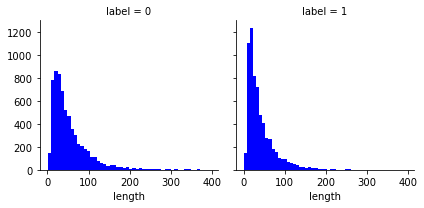

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
# COMPARING TEXT LENGTH TO LABELS
# on the cleaned reviews
graph = sns.FacetGrid(data=balanced_reviews,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')
# 0 negative, 1 positive

**Confirming that thse subsets have the same distribution**

In [93]:
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
train_df['length'] = train_df['text'].apply(lambda x : len(x.strip().split(" ")))
train_df['length'].describe()

count    10394.000000
mean        47.698961
std         41.656327
min          1.000000
25%         20.000000
50%         35.000000
75%         61.000000
max        381.000000
Name: length, dtype: float64

In [94]:
train_df.head()

,text,label,categories,length
11349,second best pool las vegas pay commit day drin...,1,"Arts & Entertainment, Casinos, Hotels, Hotels ...",33
12582,went tuesday night jan weather nice course dec...,0,"Arts & Entertainment, Nightlife, Breakfast & B...",56
4547,experience duplicates reviews purchased living...,0,"Home Services, Office Cleaning, Window Washing...",16
11873,mmmmmmr sushi place lost sushi virginity place...,1,"Restaurants, Sushi Bars, Japanese",54
12416,little strip provide monorail service lvh stri...,1,"Casinos, Nightlife, Restaurants, Hotels & Trav...",22


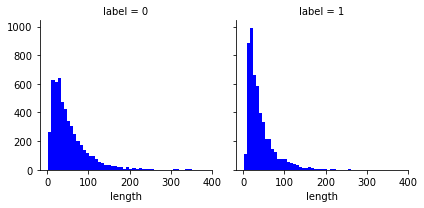

In [95]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=train_df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')
# 0 negative, 1 positive

In [96]:
validation_df['length'] = validation_df['text'].apply(lambda x : len(x.strip().split(" ")))
validation_df['length'].describe()

count    1949.000000
mean       47.949718
std        43.528609
min         1.000000
25%        20.000000
50%        34.000000
75%        62.000000
max       396.000000
Name: length, dtype: float64

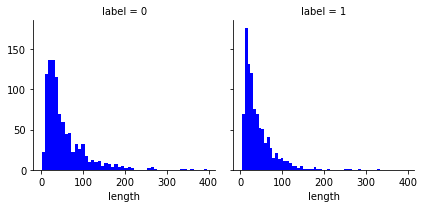

In [97]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=validation_df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')

In [98]:
test_df['length'] = test_df['text'].apply(lambda x : len(x.strip().split(" ")))
test_df['length'].describe()

count    650.000000
mean      47.821538
std       44.897303
min        4.000000
25%       20.000000
50%       34.000000
75%       60.000000
max      371.000000
Name: length, dtype: float64

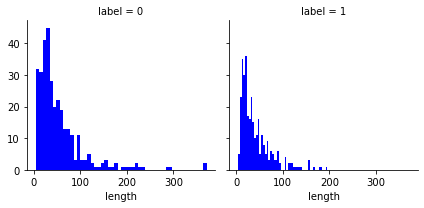

In [99]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=test_df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')